In [1]:
import pandas as pd
import numpy as np
import pickle

import tomotopy as tp

import sys

import gensim
from gensim.models.coherencemodel import CoherenceModel

import time

from collections import Counter

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression as lm

import matplotlib.pyplot as plt

import matplotlib.collections as mcol
from matplotlib.legend_handler import HandlerLineCollection, HandlerTuple
from matplotlib.lines import Line2D

In [2]:
df = pd.read_pickle("../dspg20RnD/data/final/dashboard_data/pandemic_corpus.pkl")
docs = df["final_frqwds_removed"]

In [3]:
# function to get topic word distributions
def list_topics_hpam(mdl, top_n):
    
    topic_words = []
    
    for k in range(1 + mdl.k1 + mdl.k2):
        topic_words.append([words[0] for words in mdl.get_topic_words(k, top_n)])
    
    return topic_words

In [4]:
# hPAM topic dist
# function to get level of each topic as well as top 10 words in dist
def sub_topic_dist(mdl, top_n):
    
    sub_topics = []
    topic_words = []
    
    topic_words.append([-1, 0, mdl.get_topic_words(0, top_n = top_n)])
    
    for k in range(1, 1+mdl.k1):
        topic_words.append([0, k, mdl.get_topic_words(k, top_n = top_n)])
        
    for p in range(1+mdl.k1, 1+mdl.k1+mdl.k2):
        topic_words.append([1, p, mdl.get_topic_words(p, top_n = top_n)])
        
    topic_words_df = pd.DataFrame(topic_words)
    topic_words_df.columns = ['parent_level', 'topic_id', 'Top 10 words']
    
    for l in range(mdl.k1):
        subtopics = mdl.get_sub_topics(l, top_n = 3)
        sub_topics.append(subtopics)
      
    sub_topic_df = pd.DataFrame(sub_topics)

    return topic_words_df, sub_topic_df

In [5]:
def createTCvars(docs):
    
    # Create Dictionary
    id2word = gensim.corpora.Dictionary(docs)

    # Create Corpus (Term Document Frequency)

    #Creates a count for each unique word appearing in the document, where the word_id is substituted for the word
    corpus = [id2word.doc2bow(doc) for doc in docs]

    return id2word, corpus

In [6]:
docs_dict, docs_corpus = createTCvars(docs)

In [7]:
# optimal hPAM parameters
alpha = 0.25
eta = 0.3
min_cf = 50
rm_top = 0
k1 = 5
k2 = 30

# Run hPAM

In [8]:
# initialize hierarchical PA model                                                                                 
mdl = tp.HPAModel(tw = tp.TermWeight.IDF, 
                  min_cf = min_cf, 
                  rm_top = rm_top,
                  k1 = k1, 
                  k2 = k2, 
                  alpha = alpha, 
                  eta = eta,
                  seed = 321)

# load docs
for abstracts in docs:
    mdl.add_doc(abstracts)

# setup model                                                                                                                          
mdl.burn_in = 100
mdl.train(0)

# train model
for i in range(0, 1000, 10):
    mdl.train(10)
    #print('Iteration: {}\tLog-likelihood: {}'.format(i, mdl.ll_per_word))

# create list of topics
topics = list_topics_hpam(mdl, top_n = 10)

# calculate topic coherence
cm = CoherenceModel(topics = topics, corpus = docs_corpus, dictionary = docs_dict, 
                    texts = docs, coherence = 'c_v', processes = 8)

cv = cm.get_coherence()

# get topic distributions
topic_words_df, sub_topic_df = sub_topic_dist(mdl, top_n = 10)

# Topic Labeling

In [9]:
# extract candidates for auto topic labeling
extractor = tp.label.PMIExtractor(min_cf = min_cf, min_df = 0, max_len = 5, max_cand = 10000)
cands = extractor.extract(mdl)

# ranking the candidates of labels for a specific topic
labeler = tp.label.FoRelevance(mdl, cands, min_df = 0, smoothing = 1e-2, mu = 0.25)

label_lst = []
for p in range(1+mdl.k1+mdl.k2):
    label_lst.append(label for label, score in labeler.get_topic_labels(p, top_n = 5))

label_df = pd.DataFrame(label_lst)
label_df.columns = ['Label 1', 'Label 2', 'Label 3', 'Label 4', 'Label 5']

topic_words_label_df = pd.concat([topic_words_df.reset_index(drop = True), label_df], axis = 1)

In [ ]:
topic_words_label_df.to_csv(r'hpam_results/pandemics/hpam_pandemics_optimal_topic_words.csv', index = False)

In [ ]:
sub_topic_df.to_csv(r'hpam_results/hpam_pandemics_optimal_subtopic.csv', index = False)

# Extract highest probability topic for each document

In [11]:
num_topics = 1 + mdl.k1 + mdl.k2

In [12]:
def create_doc_topic(mdl):
    
    doc_topic = []
    
    for d in range(len(mdl.docs)):
        doc_topic.append(list(mdl.docs[d].get_topic_dist()))
    
    return pd.DataFrame(doc_topic, columns=[str(i) for i in range(num_topics)])

In [13]:
doc_topic_mat = create_doc_topic(mdl)

In [14]:
max_topic = list(map(int, doc_topic_mat.idxmax(axis = 1)))
max_topic_prob = list(doc_topic_mat.max(axis = 1))

max_topic_mat = pd.DataFrame({
'topic_id': max_topic,
'max_topic_prob': max_topic_prob
})

In [15]:
max_topic_mat = max_topic_mat.merge(topic_words_label_df[['topic_id', "Top 10 words"]],
                                    on = 'topic_id',
                                    how = 'left')

In [16]:
max_topic_mat['doc'] = list(docs)

In [ ]:
max_topic_mat.to_csv('hpam_results/pandemics/hpam_pandemics_optimal_doc_max_topic.csv', index = False)

# Plot hottest and coldest topics

In [17]:
def getYear(a):   
    a = str(a)
    if a.find("/"):
        splitdate = a.split("/")
        if len(splitdate) == 3:
            a = splitdate[2]
        else:
            a = splitdate[0]
    year = str(a)
    return year

In [18]:
df['START_YEAR'] = df['PROJECT_START_DATE'].apply(getYear)

In [19]:
doc_topic_mat['START_YEAR'] = list(df['START_YEAR'])

In [20]:
topic_frame = doc_topic_mat.groupby("START_YEAR").mean().reset_index()
topic_frame = topic_frame.sort_values(by = "START_YEAR")
topic_frame["START_YEAR"] = topic_frame["START_YEAR"].astype(int)

In [22]:
# filter topic_frame for years 2010 - 2019
topic_pr_2010_2019 = topic_frame[topic_frame["START_YEAR"] > 2009] 
topic_pr_2010_2019 = topic_pr_2010_2019[topic_pr_2010_2019["START_YEAR"] < 2020] 

In [23]:
topic_slopes = []
topic_slopes_se = []
topic_results = {}

lm_x = topic_pr_2010_2019["START_YEAR"].values.reshape(-1,1)
lm_x = sm.add_constant(lm_x)

for i in range(1, num_topics+1):

    linear_fit = sm.OLS(topic_pr_2010_2019.iloc[:,i].values.reshape(-1,1),lm_x).fit()
    
    topic_slopes.append(linear_fit.params[1])
    topic_slopes_se.append(linear_fit.bse[1])
    topic_results[i] = linear_fit.params[1]

In [24]:
hot_cold = []

for slope in topic_slopes:
    if slope > 0:
        hot_cold.append("hot")
    else:
        hot_cold.append("cold")

In [25]:
class HandlerDashedLines(HandlerLineCollection):
    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):
        # figure out how many lines there are
        numlines = len(orig_handle.get_segments())
        xdata, xdata_marker = self.get_xdata(legend, xdescent, ydescent,
                                             width, height, fontsize)
        leglines = []
        # divide the vertical space where the lines will go
        # into equal parts based on the number of lines
        ydata = np.full_like(xdata, height / (numlines + 1))
        # for each line, create the line at the proper location
        # and set the dash pattern
        for i in range(numlines):
            legline = Line2D(xdata, ydata * (numlines - i) - ydescent)
            self.update_prop(legline, orig_handle, legend)
            # set color, dash pattern, and linewidth to that
            # of the lines in linecollection
            try:
                color = orig_handle.get_colors()[i]
            except IndexError:
                color = orig_handle.get_colors()[0]
            try:
                dashes = orig_handle.get_dashes()[i]
            except IndexError:
                dashes = orig_handle.get_dashes()[0]
            try:
                lw = orig_handle.get_linewidths()[i]
            except IndexError:
                lw = orig_handle.get_linewidths()[0]
            if dashes[0] is not None:
                legline.set_dashes(dashes[1])
            legline.set_color(color)
            legline.set_transform(trans)
            legline.set_linewidth(lw)
            leglines.append(legline)
        return leglines

In [26]:
def create_legend(mdl, top_n = 5):

    topic_words = []
    
    for k in range(1 + mdl.k1 + mdl.k2):
        topic_words.append([words[0] for words in mdl.get_topic_words(k, top_n)])
        
    str_wds = []
    
    for wds in topic_words:
        str_wds.append(", ".join(wds))   
        
    return str_wds

In [27]:
def sort_dict(x):
    return sorted(x.items(), key=lambda l: l[1], reverse=True)

In [28]:
sort_slopes = sort_dict(topic_results)
top_slopes = [x[0] for x in sort_slopes[:10]]
bottom_slopes = [x[0] for x in sort_slopes[-10:]]

In [29]:
leg = create_legend(mdl, 5)

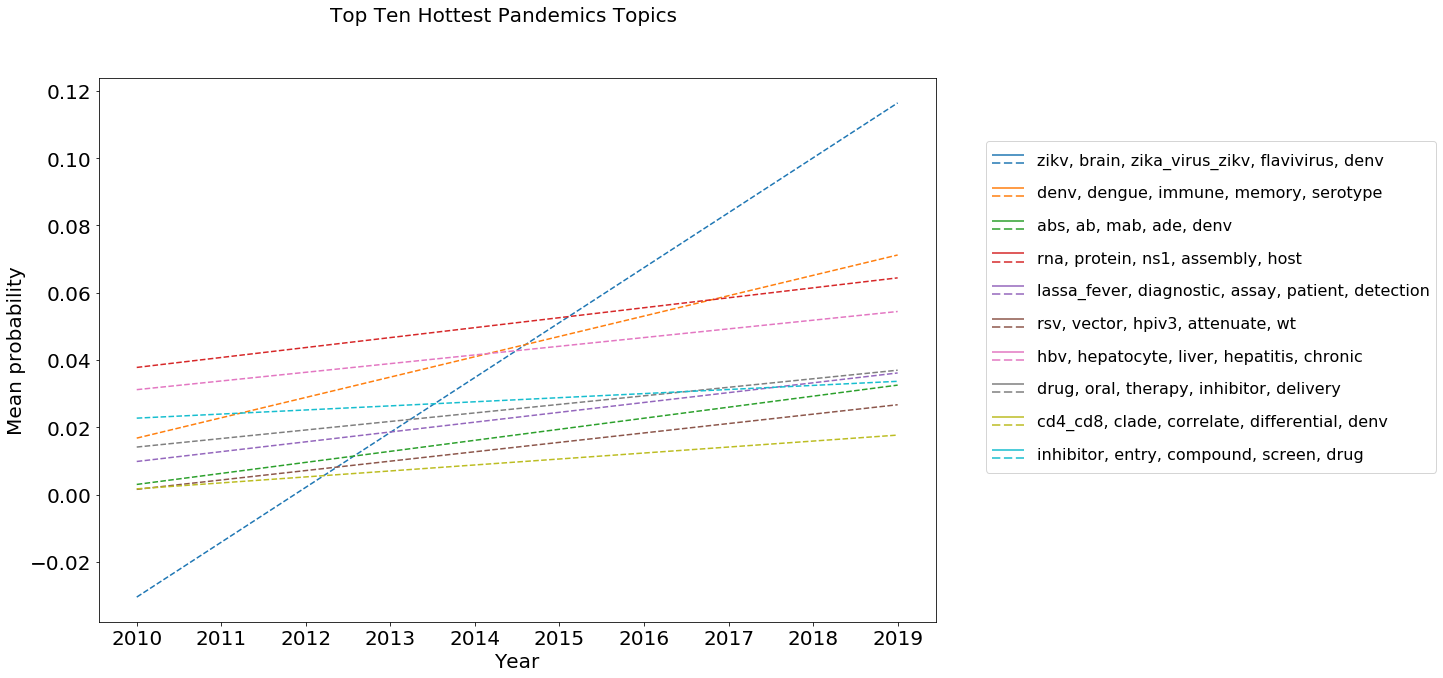

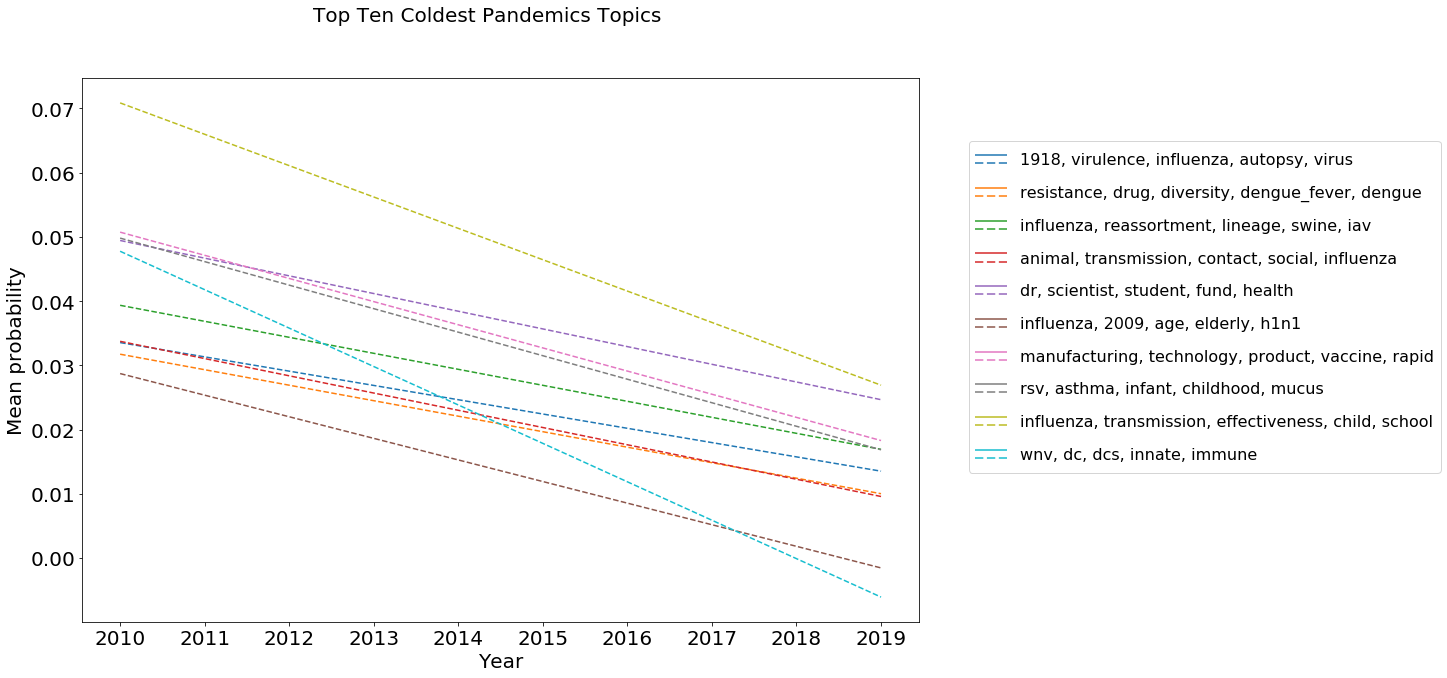

In [31]:
# Make Graphs
color_list = plt.rcParams['axes.prop_cycle'].by_key()['color']

# hottest topics

line_return = []
fig = plt.figure(figsize=(15,10))
fig.suptitle('Top Ten Hottest Pandemics Topics', fontsize=20)
ax = fig.add_subplot(111)
line = [[(0, 0)]]
i = 0
for n in top_slopes:
    linear_fit = lm().fit(topic_pr_2010_2019["START_YEAR"].values.reshape(-1,1), topic_pr_2010_2019.iloc[:,n].values.reshape(-1,1))
    ax.plot(topic_pr_2010_2019["START_YEAR"], (topic_pr_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    #ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o')
    #ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
                #yerr = np.array(topic_wts_se_2010_2019.iloc[:,n-1]), fmt = "o")
    line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    i+=1

plt.xticks(np.arange(topic_pr_2010_2019["START_YEAR"].min(), topic_pr_2010_2019["START_YEAR"].max()+1, 1.0),fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Mean probability', fontsize=20)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
plt.legend(line_return, [leg[x-1] for x in top_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left',fontsize=16)
plt.savefig("hpam_results/pandemics/hpam_pandemics_optimal_hot_topics.png", dpi = 800, bbox_inches='tight')
plt.show()

# coldest topics

line_return = []
fig = plt.figure(figsize=(15,10))
fig.suptitle('Top Ten Coldest Pandemics Topics', fontsize=20)
ax = fig.add_subplot(111)
i = 0
for n in bottom_slopes:
    linear_fit = lm().fit(topic_pr_2010_2019["START_YEAR"].values.reshape(-1,1), topic_pr_2010_2019.iloc[:,n].values.reshape(-1,1))
    ax.plot(topic_pr_2010_2019["START_YEAR"], (topic_pr_2010_2019["START_YEAR"]*linear_fit.coef_[0][0])+linear_fit.intercept_,linestyle = 'dashed', color = color_list[i])
    #ax.plot(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], '-o', color=color_list[i+5])
    #ax.scatter(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], color=color_list[i+5])
    #ax.errorbar(topic_wts_2010_2019["START_YEAR"], topic_wts_2010_2019.iloc[:,n], 
                #yerr = np.array(topic_wts_se_2010_2019.iloc[:,n-1]), fmt = "o",
                #color=color_list[i+5])
    line_return.append(mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=[color_list[i],color_list[i]]))
    i+=1

plt.xticks(np.arange(topic_pr_2010_2019["START_YEAR"].min(), topic_pr_2010_2019["START_YEAR"].max()+1, 1.0), fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('Year', fontsize=20)
plt.ylabel('Mean probability', fontsize=20)

# set up the proxy artist
lc = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['blue','blue'])
lc2 = mcol.LineCollection(2 * line, linestyles=['solid','dashed'], colors=['orange','orange'])

# create the legend
plt.legend(line_return, [leg[x-1] for x in bottom_slopes], handler_map={type(line_return[0]): HandlerDashedLines()},
          handlelength=2, handleheight=2,bbox_to_anchor=(1.05, 0.7, 0.3, 0.2), loc='upper left', fontsize=16)

plt.savefig("hpam_results/pandemics/hpam_pandemics_optimal_cold_topics.png", dpi = 800, bbox_inches='tight')
plt.show()